<a href="https://colab.research.google.com/github/mopheiok/hands_on_sk_tf/blob/master/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 获取数据

In [0]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    

MAP_PATH = os.path.join("images", CHAPTER_ID)
MAP_URL = DOWNLOAD_ROOT + "images/end_to_end_project/california.png"

def fetch_california_map(map_url=MAP_URL, map_path=MAP_PATH):
  if not os.path.isdir(map_path):
    os.makedirs(map_path)
  map_path_local = os.path.join(map_path, "california.png")
  urllib.request.urlretrieve(map_url, map_path_local)

In [0]:
fetch_housing_data()
fetch_california_map()

In [0]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## 快速查看数据结构

In [9]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [11]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [12]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure attribute_histogram_plots


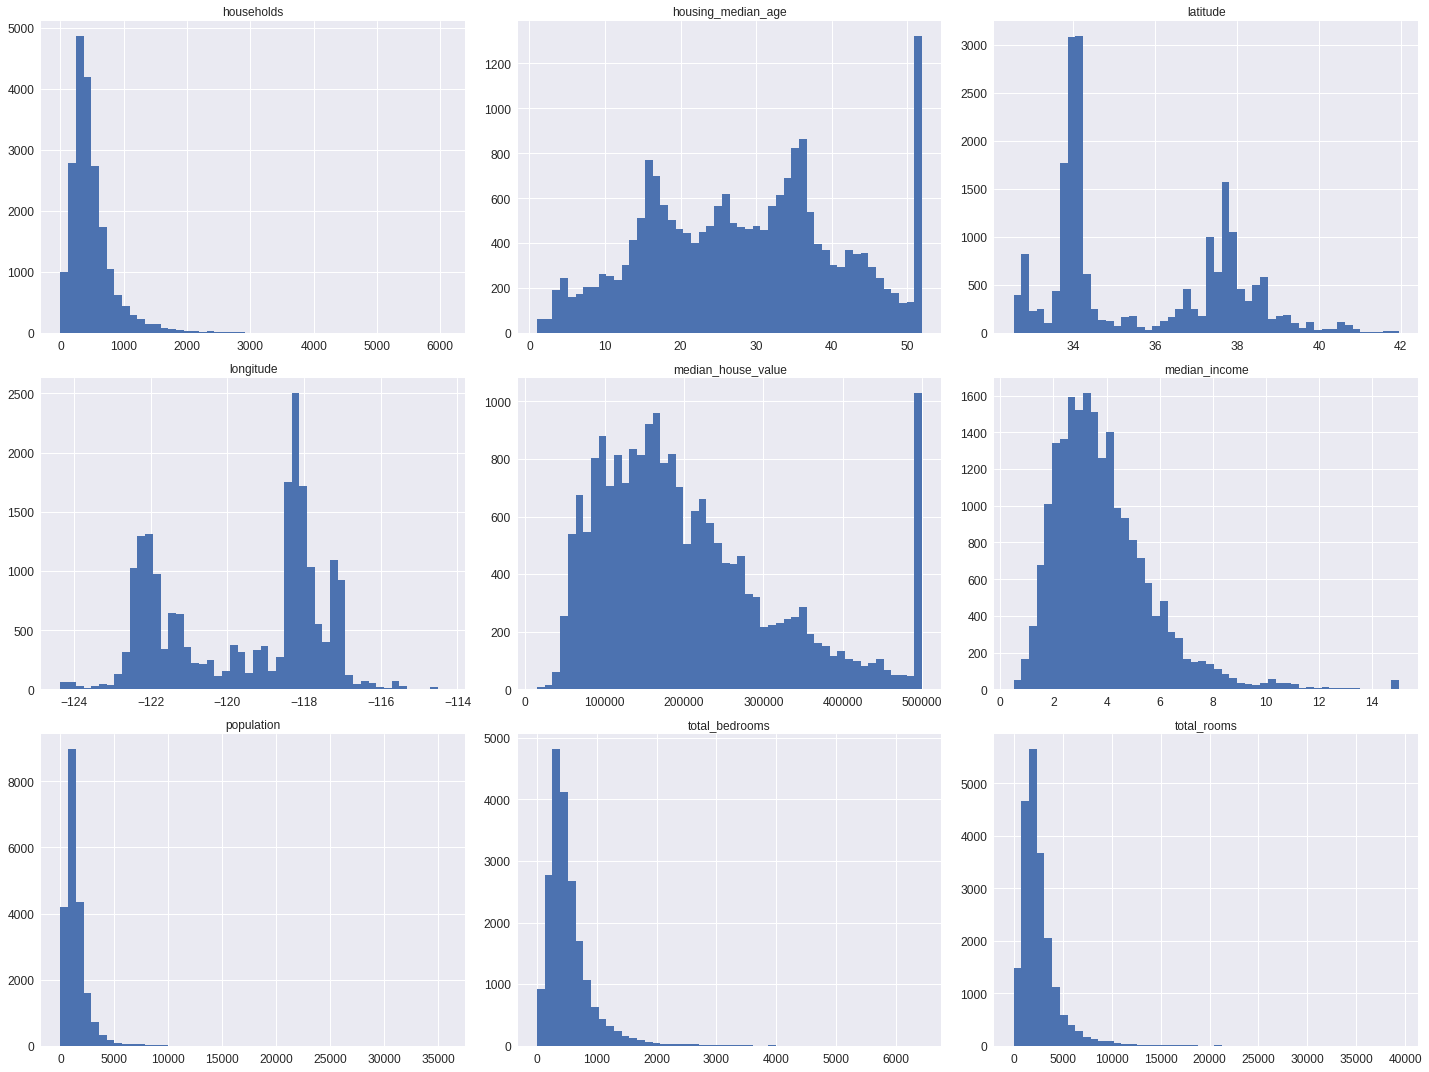

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

## 创建训练集和测试集

### 自定义分割方法

In [0]:
# to make this notebook's output identical at every run
np.random.seed(42)

在分割数据集的过程中，再次执行分割过程就会产生不同的测试集。多次运行之后，算法就会得到整个数据集，这是需要避免的。

其方法有二：

 - 将第一次得到的测试集保存起来
 - 设置随机数生成器的种子， 以产生总是相同的洗牌指数

In [0]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) # 对数据索引进行洗牌，即打乱数据原有顺序
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [16]:
data_test =np.arange(5)
data_test

array([0, 1, 2, 3, 4])

In [17]:
# Permutation 排列 Combination 组合
np.random.permutation(len(data_test)) # 产生随机排列

array([1, 4, 2, 0, 3])

In [18]:
train_set, test_set = split_train_test(housing, 0.2) # 对数据集进行2:8分裂
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


但是如果数据集更新（*即在原数据集基础上新增加数据*），这两个方法都会失效。一个通常的解决办法是使用每个实例的ID来判定这个实例是否应该放入测试集（假设每个实例都有唯一并且不变的ID）。

例如，你可以计算出每个实例ID的哈希值，只保留其最后一个字节，如果该值小于等于 51（约为 256 的 20%），就将其放入测试集。这样可以保证在多次运行中，测试集保持不变，即使更新了数据集。新的测试集会包含新实例中的 20%，但不会有之前位于训练集的实例（*因为根据原数据集的 ID中已经将 $< 51$ 的数据归入测试集，新更新的数据中若有小于51的，则也归入测试集，所以原数据集的分割没有变化，新加入的数据进行了再分割，将原测试集增大*）。下面是一种可用的方法：

[循环冗余校验](https://colobu.com/2014/10/22/CRC-introduction/)（英语：Cyclic redundancy check，通称“CRC”）是一种根据数据产生简短固定位数校验码的一种散列函數，主要用来检测或校验数据传输或者保存后可能出现的错误。一般来说，循环冗余校验的值都是32位的整数。

[散列函数](https://zh.wikipedia.org/wiki/%E6%95%A3%E5%88%97%E5%87%BD%E6%95%B8)（英语：Hash function）又称散列算法、哈希函数，是一种从任何一种数据中创建小的数字“指纹”的方法。

In [0]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [20]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


[LBS知识之经纬度精度](https://www.biaodianfu.com/lbs-precision.html)
只需要精确到小数点后7位，精度就是1CM，因此，数据库保存经纬度采用 decimal(10,7) 即可

问题1：为什么不采用float?

答：float,double容易产生误差，对精确度要求比较高时，建议使用decimal来存，decimal在mysql内存是以字符串存储的

问题2：为什么不用字符串？

答：字符串不方便数据库计算

In [21]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"] #使用经纬度构造ID
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
print(len(train_set), "train +", len(test_set), "test")

16322 train + 4318 test


### 使用Scikit-Learn 提供的函数分割数据集

In [0]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### 分层采样

无论自定义分割还是Scikit-Learn中内置的分割方法，采用的都是纯随机抽取方法。当数据集很大时（尤其是和属性数相比），这通常可行；但如果数据集不大，就会有采样偏差的风险。为了避免这种偏差，有时会采用“**分层采样**”（stratified sampling），比如，先将人群按性别分为两个子组，即分层，再从每个分层去取合适数量的实例，以保证测试集男女比例无偏差，此时对总人数有代表性。

中位数是预测房价中位数非常重要的属性。想要保证测试集可以代表整体数据集中的多种收入分类，所以对中位数进行分层采样处理。

#### 观察数据整体分布

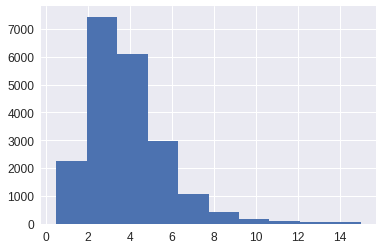

In [23]:
housing["median_income"].hist()

#### 对数据划分子组

数据集中的每个分层都要有足够的实例位于数据中，这点很重要。否则，对分层重要性的评估就会有偏差。所以，不能有过多的分层，且每个分层都要足够大。通过将收入中位数除以 1.5（以限制收入分类的数量），创建了一个收入类别属性，用ceil对值舍入（以产生离散的分类）

In [0]:
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
#返回一个同样shape的df，当满足条件为TRUE时，从本身返回结果，否则从返回其他df的结果
housing["income_cat"].where(housing["income_cat"] < 5, other=5.0, inplace=True)

使用pandas内置函数`cut()`同样实现上述功能，更简单易懂。bins表示分割区间，labels对每个区间的标签

In [0]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [26]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

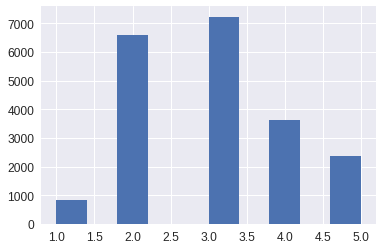

In [27]:
housing["income_cat"].hist()

#### 对各层采样

使用 Scikit-Learn 的[StratifiedShuffleSplit](https://blog.csdn.net/u012193416/article/details/79313601)类进行分层采样

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [29]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set) # 测试集中各个类别所占比例

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [30]:
housing["income_cat"].value_counts() / len(housing) # 完整数据集中各类别比例

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

### 对比总数据集、分层采样的测试集、纯随机采样测试集的收入分类比例

In [0]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()

# 误差绝对值越大，偏差越严重
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [32]:
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1,0.039826,0.040213,0.039729,0.973236,-0.243309
2,0.318847,0.324370,0.318798,1.732260,-0.015195
3,0.350581,0.358527,0.350533,2.266446,-0.013820
4,0.176308,0.167393,0.176357,-5.056334,0.027480
5,0.114438,0.109496,0.114583,-4.318374,0.127011


In [0]:
# 删除income_cat属性，使数据回到初始状态
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## 数据探索和可视化、发现规律

In [0]:
# 创建一个副本，以免损伤训练集
housing = strat_train_set.copy()

### 地理数据可视化

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Saving figure bad_visualization_plot


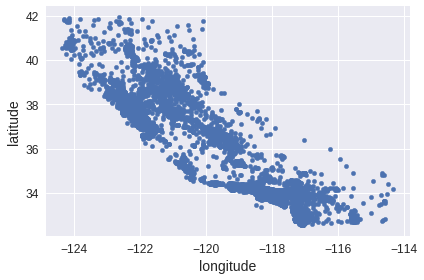

In [35]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

将`alpha`设为 0.1，可以更容易看出数据点的密度

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Saving figure better_visualization_plot


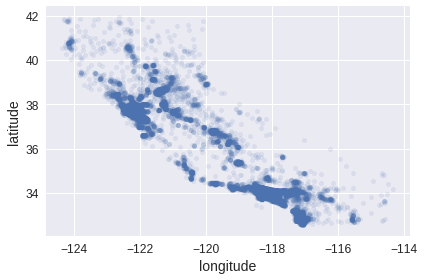

In [44]:
# 显示高密度区域的散点图
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

Saving figure housing_prices_scatterplot


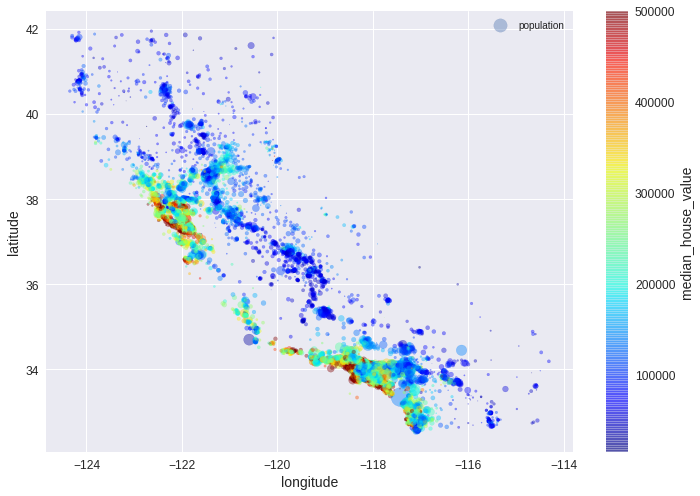

In [41]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

Saving figure california_housing_prices_plot


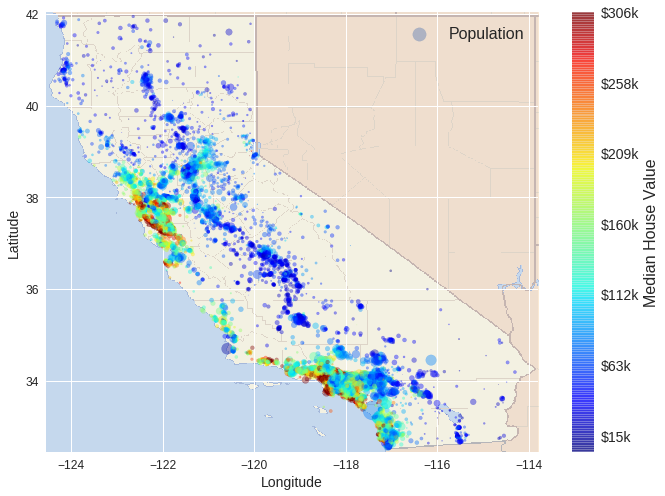

In [45]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

### 查找关联

使用`corr()`方法计算出每对属性间的标准相关系数（standard correlation coefficient，也称作[皮尔逊相关系数](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)）

In [0]:
corr_matrix = housing.corr()

In [47]:
# 每个属性和房价中位数的关联度
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

相关系数在横轴和纵轴之间的不同图形

![](https://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg)

Saving figure scatter_matrix_plot


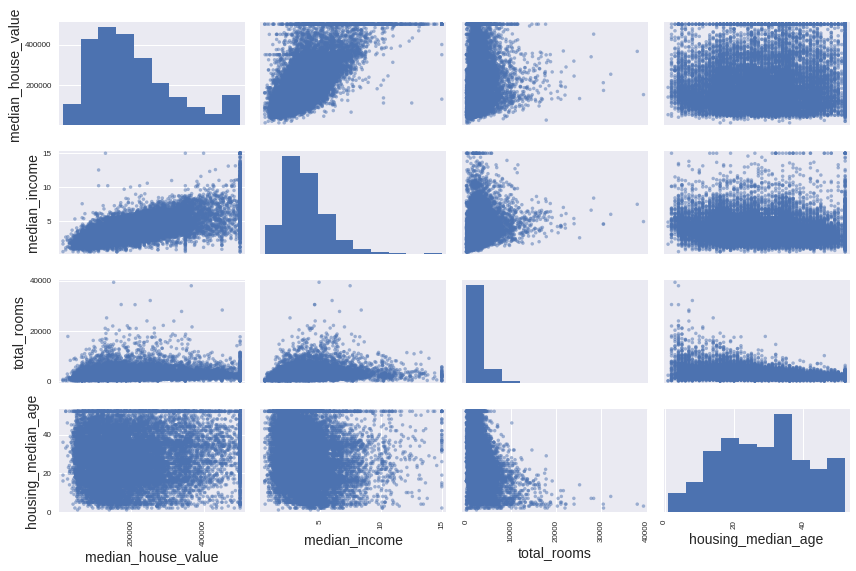

In [49]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

从散点图矩阵中观察到最有希望用来预测房价中位数的属性是收入中位数，因此将这张图放大

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Saving figure income_vs_house_value_scatterplot


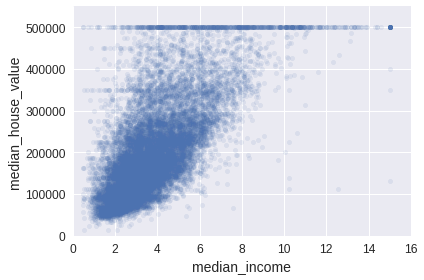

In [50]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

这张图说明了几点。
 1. 相关性非常高；可以清晰地看到向上的趋势，并且数据点不是非常分散
 2. 之前看到的最高价，清晰地呈现为一条位于 500000 美元的水平线。这张图也呈现了一些不是那么明显的直线：一条位于 450000 美元的直线，一条位于 350000 美元的直线，一条在 280000 美元的线，和一些更靠下的线。希望去除对应的街区，以防止算法重复这些巧合。

### 属性组合实验